In [1]:
from datasets import load_dataset

ds = load_dataset("bahjat-kawar/tedbench", split="val")

In [2]:
import torch
from transformers import CLIPTextModel, CLIPTokenizer
device = torch.device(
    "cuda" if torch.cuda.is_available() else "cpu"
)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch16").to(device)
text_encoder.eval()
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch16")

c:\Users\Admin\miniconda3\envs\tf-gpu\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [3]:
# Load Stable Diffusion VAE
from diffusers import AutoencoderKL
VAE_id = "stabilityai/sdxl-vae"
vae = AutoencoderKL.from_pretrained(VAE_id).to(device)
vae.requires_grad_(False)
vae.eval()

AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
          )
        )
      )
      (1): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (c

In [4]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

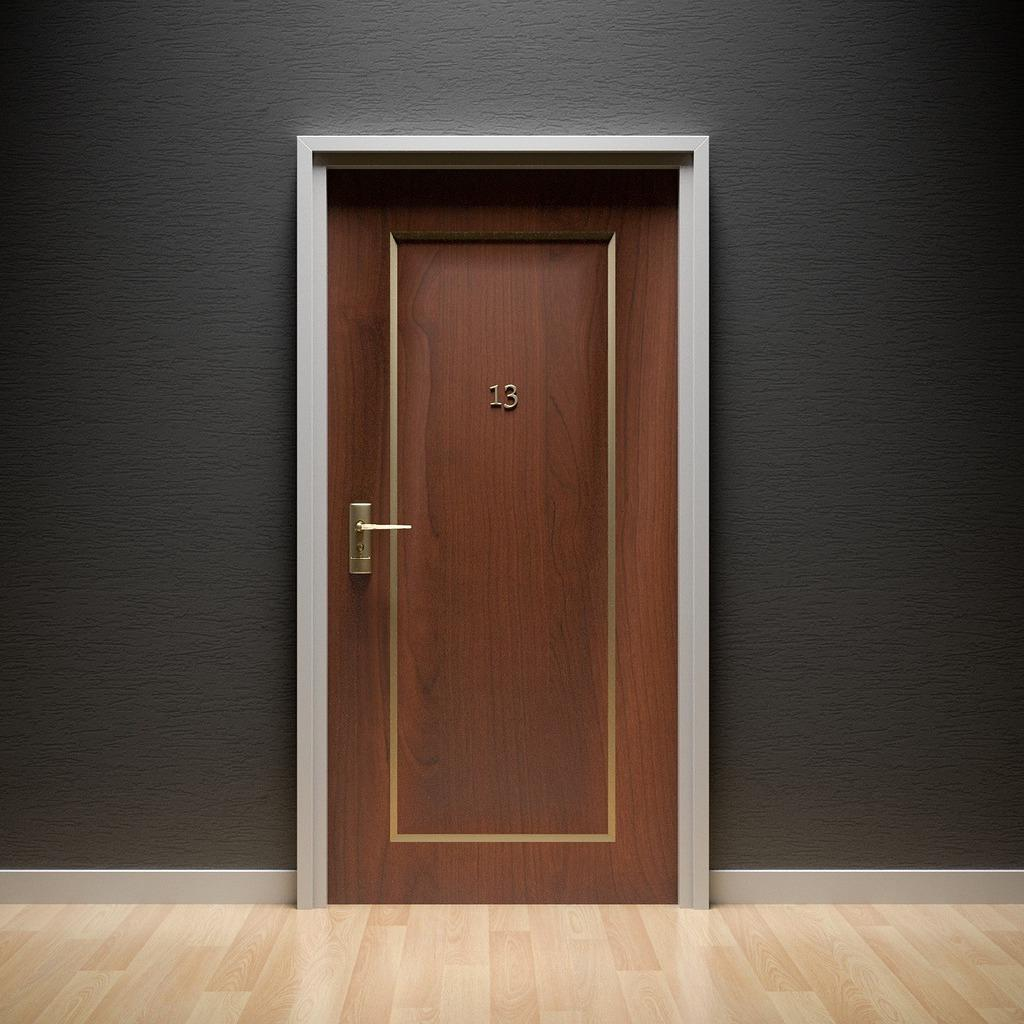

In [5]:
ds[5]["original_image"]

In [6]:
from torch.utils.data import Dataset, DataLoader


class TextGuidedImageGenerationDataset(Dataset):
    def __init__(self, dataset, transform, text_encoder, tokenizer, device):
        self.dataset = dataset
        self.transform = transform
        self.text_encoder = text_encoder
        self.device = device
        self.original_images = dataset["original_image"]
        self.captions = dataset["caption"]
        self.edited_images = dataset["edited_image"]
        self.tokenizer = tokenizer
        self.cache = {}

    def convert_to_rgb(self, image):
        """Convert image to RGB if it has 4 channels (RGBA)"""
        if image.mode == "RGBA":
            # Convert RGBA to RGB by removing alpha channel
            return image.convert("RGB")
        return image

    def get_embed(self, caption):
        inputs = self.tokenizer(
            caption, truncation=True, padding=True, return_tensors="pt"
        ).to(self.device)
        self.text_encoder.eval()
        with torch.no_grad():
            # Use mean pooling instead of just the first token
            text_features = self.text_encoder(**inputs).last_hidden_state
            # Mean pooling
            text_features = text_features.mean(dim=1)
        return text_features.squeeze(0)

    def __len__(self):
        return len(self.captions)

    def __getitem__(self, idx):
        if idx in self.cache:
            return self.cache[idx]

        original_image = self.convert_to_rgb(self.original_images[idx])
        transform_original_image = self.transform(original_image)

        with torch.no_grad():
            latent_original_image = (
                vae.encode(transform_original_image.unsqueeze(0).to(self.device))
                .latent_dist.sample()
                .squeeze(0)
                * 0.18215
            )

        edited_image = self.convert_to_rgb(self.edited_images[idx])
        transform_ed_image = self.transform(edited_image)

        with torch.no_grad():
            latent_edited_image = (
                vae.encode(transform_ed_image.unsqueeze(0).to(self.device))
                .latent_dist.sample()
                .squeeze(0)
                * 0.18215
            )

        caption = self.captions[idx]
        caption_embedding = self.get_embed(caption)

        sample = {
            "latent_original_image": latent_original_image,
            "latent_edited_image": latent_edited_image,
            "caption": caption,
            "caption_embedding": caption_embedding,
        }

        self.cache[idx] = sample
        return sample


train_ds = TextGuidedImageGenerationDataset(
    ds, transform, text_encoder, tokenizer, device
)
train_loader = DataLoader(train_ds, batch_size=25, shuffle=True)

In [7]:
sample = next(iter(train_ds))

c:\Users\Admin\miniconda3\envs\tf-gpu\lib\site-packages\diffusers\models\attention_processor.py:3313: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  hidden_states = F.scaled_dot_product_attention(


## **Model**

In [11]:
import math
import torch.nn as nn
from torchcfm.models.unet import UNetModel


def timestep_embedding(timesteps, dim, max_period=10000):
    """Create sinusoidal timestep embeddings.

    :param timesteps: a 1-D Tensor of N indices, one per batch element. These may be fractional.
    :param dim: the dimension of the output.
    :param max_period: controls the minimum frequency of the embeddings.
    :return: an [N x dim] Tensor of positional embeddings.
    """
    half = dim // 2
    freqs = torch.exp(
        -math.log(max_period)
        * torch.arange(start=0, end=half, dtype=torch.float32, device=timesteps.device)
        / half
    )
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding


class UNetModelWithTextEmbedding(UNetModel):
    def __init__(
        self, dim, num_channels, num_res_blocks, embedding_dim, *args, **kwargs
    ):
        super().__init__(dim, num_channels, num_res_blocks, *args, **kwargs)

        self.image_encoder = nn.Sequential(
            nn.Conv2d(4, num_channels, kernel_size=3, stride=2, padding=1),  # half size
            nn.SiLU(),
            nn.Conv2d(
                num_channels, num_channels * 2, kernel_size=3, stride=2, padding=1
            ),  # half size
            nn.SiLU(),
            nn.Conv2d(
                num_channels * 2, num_channels * 4, kernel_size=3, stride=2, padding=1
            ),  # half size
            nn.SiLU(),
            nn.AdaptiveAvgPool2d(1),  # shape: (batch_size, num_channels*4, 1, 1)
        )

        self.embedding_layer = nn.Linear(embedding_dim, num_channels * 4)
        self.fc = nn.Linear(num_channels * 12, num_channels * 4)
        self.null_condition_vector = nn.Parameter(torch.randn(1, embedding_dim))
        self.null_image_vector = nn.Parameter(torch.randn(1, dim[0], dim[1], dim[2]))
        self.register_parameter("null_condition_vector", self.null_condition_vector)
        self.register_parameter("null_image_vector", self.null_image_vector)

    def forward(self, t, x, text_embeddings=None, original_image=None):
        """Apply the model to an input batch, incorporating text embeddings."""
        timesteps = t

        while timesteps.dim() > 1:
            timesteps = timesteps[:, 0]
        if timesteps.dim() == 0:
            timesteps = timesteps.repeat(x.shape[0])

        hs = []
        emb = self.time_embed(timestep_embedding(timesteps, self.model_channels))

        if (text_embeddings is not None) and (original_image is not None):
            text_embedded = self.embedding_layer(text_embeddings)
            image_embedded = self.image_encoder(original_image).squeeze(2).squeeze(2)
            emb = torch.cat([emb, text_embedded, image_embedded], dim=1)  # 128*3
            emb = self.fc(emb)

        h = x.type(self.dtype)
        for module in self.input_blocks:
            h = module(h, emb)
            hs.append(h)
        h = self.middle_block(h, emb)
        for module in self.output_blocks:
            h = torch.cat([h, hs.pop()], dim=1)
            h = module(h, emb)
        h = h.type(x.dtype)
        return self.out(h)

In [12]:
model = UNetModelWithTextEmbedding(
    dim=(4, 64, 64), num_channels=64, num_res_blocks=1, embedding_dim=512, dropout=0.05, num_heads=1
).to(device)
optimizer = torch.optim.AdamW(model.parameters())

In [13]:
from tqdm import tqdm
import math

n_epochs = 5_000

initial_drop_prob = 0.5  # càng cao thì càng nhiều điều kiện bị drop
final_drop_prob = 0.2
sigma = 1e-5


# def get_drop_prob(epoch):
#     # Cosine schedule
#     alpha = epoch / n_epochs
#     return final_drop_prob + 0.5 * (initial_drop_prob - final_drop_prob) * (
#         1 + math.cos(math.pi * alpha)
#     )


for epoch in tqdm(range(n_epochs)):
    losses = []
    drop_cond_prob = 0.5  # Probability of dropping condition

    for batch in train_loader:
        optimizer.zero_grad()
        # x1_latent: latent edited image (target)
        x1_latent = batch["latent_edited_image"].to(device)
        # original image latent (dùng làm điều kiện image)
        cond_image = batch["latent_original_image"].to(device)
        # text embeddings (caption)
        text_embeddings = batch["caption_embedding"].to(device)

        # Expand null condition vector cho text (learnable)
        null_text = model.null_condition_vector.expand(x1_latent.size(0), -1)
        # Null condition cho image: ta dùng zeros (hoặc có thể thiết kế learnable sau này)
        null_image = model.null_image_vector.expand(x1_latent.size(0), -1, -1, -1)

        # Tạo mask dropout độc lập cho text và image
        use_text = (
            (torch.rand(x1_latent.size(0)) > drop_cond_prob)
            .float()
            .to(device)
            .unsqueeze(1)
        )
        use_image = (
            (torch.rand(x1_latent.size(0)) > drop_cond_prob)
            .float()
            .to(device)
            .view(-1, 1, 1, 1)
        )

        # Áp dụng mask: nếu bị drop, thay bằng null condition
        text_embeddings = use_text * text_embeddings + (1 - use_text) * null_text
        cond_image = use_image * cond_image + (1 - use_image) * null_image

        # Tạo x0 (noise) và chọn timestep t ngẫu nhiên
        x0 = torch.randn_like(x1_latent).to(device)
        t = torch.rand(x0.shape[0], 1, 1, 1).to(device)
        t_flat = t.view(x0.size(0))

        # Giả lập x_t: kết hợp giữa target (x1_latent) và noise (x0) theo t
        xt = t * x1_latent + (1 - (1 - sigma) * t) * x0
        ut = x1_latent - (1 - sigma) * x0  # Target vector field

        # Forward pass với điều kiện đã được mask cho cả text và image
        vt = model(
            t_flat, xt, text_embeddings=text_embeddings, original_image=cond_image
        )
        
        loss = torch.mean((vt - ut) ** 2)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        losses.append(loss.item())

    avg_loss = sum(losses) / len(losses)
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {avg_loss:.4f}")

  2%|▏         | 100/5000 [00:21<17:13,  4.74it/s]

Epoch [100/5000], Loss: 1.1660


  4%|▍         | 201/5000 [00:43<16:53,  4.74it/s]

Epoch [200/5000], Loss: 1.0718


  6%|▌         | 300/5000 [01:04<17:09,  4.57it/s]

Epoch [300/5000], Loss: 1.0019


  8%|▊         | 400/5000 [01:25<16:15,  4.71it/s]

Epoch [400/5000], Loss: 0.9590


 10%|█         | 500/5000 [01:46<16:27,  4.56it/s]

Epoch [500/5000], Loss: 0.8534


 12%|█▏        | 600/5000 [02:08<16:05,  4.56it/s]

Epoch [600/5000], Loss: 0.7290


 14%|█▍        | 700/5000 [02:29<14:58,  4.79it/s]

Epoch [700/5000], Loss: 0.5732


 16%|█▌        | 801/5000 [02:50<14:42,  4.76it/s]

Epoch [800/5000], Loss: 0.4747


 18%|█▊        | 900/5000 [03:11<14:51,  4.60it/s]

Epoch [900/5000], Loss: 0.4460


 20%|██        | 1000/5000 [03:33<14:47,  4.51it/s]

Epoch [1000/5000], Loss: 0.3580


 22%|██▏       | 1100/5000 [03:55<14:23,  4.51it/s]

Epoch [1100/5000], Loss: 0.3574


 24%|██▍       | 1200/5000 [04:19<15:07,  4.19it/s]

Epoch [1200/5000], Loss: 0.3342


 26%|██▌       | 1300/5000 [04:43<14:52,  4.15it/s]

Epoch [1300/5000], Loss: 0.3275


 28%|██▊       | 1400/5000 [05:08<15:04,  3.98it/s]

Epoch [1400/5000], Loss: 0.3213


 30%|███       | 1500/5000 [05:33<14:29,  4.03it/s]

Epoch [1500/5000], Loss: 0.2408


 32%|███▏      | 1600/5000 [05:58<13:53,  4.08it/s]

Epoch [1600/5000], Loss: 0.2676


 34%|███▍      | 1700/5000 [06:23<14:13,  3.87it/s]

Epoch [1700/5000], Loss: 0.3213


 36%|███▌      | 1800/5000 [06:48<13:08,  4.06it/s]

Epoch [1800/5000], Loss: 0.2432


 38%|███▊      | 1900/5000 [07:13<12:38,  4.09it/s]

Epoch [1900/5000], Loss: 0.2739


 40%|████      | 2000/5000 [07:38<12:49,  3.90it/s]

Epoch [2000/5000], Loss: 0.2422


 42%|████▏     | 2100/5000 [08:01<10:37,  4.55it/s]

Epoch [2100/5000], Loss: 0.2885


 44%|████▍     | 2200/5000 [08:23<10:12,  4.57it/s]

Epoch [2200/5000], Loss: 0.2579


 46%|████▌     | 2300/5000 [08:45<10:05,  4.46it/s]

Epoch [2300/5000], Loss: 0.1817


 48%|████▊     | 2400/5000 [09:07<09:22,  4.62it/s]

Epoch [2400/5000], Loss: 0.2566


 50%|█████     | 2500/5000 [09:30<09:05,  4.59it/s]

Epoch [2500/5000], Loss: 0.2024


 52%|█████▏    | 2600/5000 [09:52<08:31,  4.69it/s]

Epoch [2600/5000], Loss: 0.2082


 54%|█████▍    | 2701/5000 [10:14<08:05,  4.74it/s]

Epoch [2700/5000], Loss: 0.1720


 56%|█████▌    | 2800/5000 [10:35<08:27,  4.34it/s]

Epoch [2800/5000], Loss: 0.2374


 58%|█████▊    | 2900/5000 [10:57<07:31,  4.65it/s]

Epoch [2900/5000], Loss: 0.2418


 60%|██████    | 3000/5000 [11:19<07:08,  4.67it/s]

Epoch [3000/5000], Loss: 0.2110


 62%|██████▏   | 3100/5000 [11:41<07:01,  4.51it/s]

Epoch [3100/5000], Loss: 0.2177


 64%|██████▍   | 3200/5000 [12:03<06:50,  4.39it/s]

Epoch [3200/5000], Loss: 0.2260


 66%|██████▌   | 3301/5000 [12:25<06:03,  4.67it/s]

Epoch [3300/5000], Loss: 0.2466


 68%|██████▊   | 3401/5000 [12:46<05:30,  4.84it/s]

Epoch [3400/5000], Loss: 0.2874


 70%|███████   | 3500/5000 [13:07<05:10,  4.83it/s]

Epoch [3500/5000], Loss: 0.2496


 72%|███████▏  | 3601/5000 [13:28<04:47,  4.87it/s]

Epoch [3600/5000], Loss: 0.2139


 74%|███████▍  | 3700/5000 [13:50<04:45,  4.56it/s]

Epoch [3700/5000], Loss: 0.2059


 76%|███████▌  | 3801/5000 [14:11<04:07,  4.84it/s]

Epoch [3800/5000], Loss: 0.1679


 78%|███████▊  | 3900/5000 [14:33<04:08,  4.43it/s]

Epoch [3900/5000], Loss: 0.2320


 80%|████████  | 4000/5000 [14:54<03:37,  4.61it/s]

Epoch [4000/5000], Loss: 0.1880


 82%|████████▏ | 4100/5000 [15:18<04:01,  3.72it/s]

Epoch [4100/5000], Loss: 0.1598


 84%|████████▍ | 4200/5000 [15:44<03:18,  4.03it/s]

Epoch [4200/5000], Loss: 0.2269


 86%|████████▌ | 4300/5000 [16:09<02:48,  4.16it/s]

Epoch [4300/5000], Loss: 0.2398


 88%|████████▊ | 4400/5000 [16:33<02:25,  4.12it/s]

Epoch [4400/5000], Loss: 0.2038


 90%|█████████ | 4500/5000 [16:57<02:09,  3.86it/s]

Epoch [4500/5000], Loss: 0.1803


 92%|█████████▏| 4600/5000 [17:22<01:37,  4.11it/s]

Epoch [4600/5000], Loss: 0.1519


 94%|█████████▍| 4700/5000 [17:47<01:13,  4.08it/s]

Epoch [4700/5000], Loss: 0.1882


 96%|█████████▌| 4800/5000 [18:12<00:49,  4.06it/s]

Epoch [4800/5000], Loss: 0.1861


 98%|█████████▊| 4900/5000 [18:36<00:24,  4.03it/s]

Epoch [4900/5000], Loss: 0.1925


100%|██████████| 5000/5000 [19:01<00:00,  4.38it/s]

Epoch [5000/5000], Loss: 0.1995


# Inference

In [72]:
model.eval()
def euler_method_with_dual_cfg(model, text_embedding, t_steps, dt, noise, original_image, gamma_text=3.0, gamma_img=1.0, null_text=None, null_image=None):
    """
    Euler method with dual CFG for both text and image conditions.
    :param model: đã được train.
    :param text_embedding: text condition (đầy đủ) [B, embedding_dim].
    :param t_steps: vector các giá trị t (ví dụ từ 0 đến 1) với số bước mong muốn.
    :param dt: bước thời gian (assumed positive).
    :param noise: mẫu noise ban đầu (x0).
    :param original_image: ảnh điều kiện đầy đủ (image condition).
    :param gamma_text: hệ số CFG cho text.
    :param gamma_img: hệ số CFG cho image.
    :param null_condition: null text condition (learnable), tương đương với model.null_condition_vector.
    :return: chuỗi các mẫu y theo thời gian.
    """
    y = noise
    y_values = []
    
    with torch.no_grad():
        for t in t_steps:
            t_val = t.to(device)
            # Dự đoán với chỉ text condition (image bị drop)
            dy_text = model(t_val, y, text_embeddings=text_embedding, original_image=original_image)
            # Dự đoán với chỉ image condition (text bị drop)
            dy_img = model(t_val, y, text_embeddings=null_text, original_image=original_image)
            # Dự đoán uncondition (không có điều kiện nào)
            dy_uncond = model(t_val, y, text_embeddings=null_text, original_image=null_image)
            
            # Tích hợp CFG kép
            dy_guided = dy_uncond + gamma_text * (dy_text - dy_img) + gamma_img * (dy_img - dy_uncond)
            
            y = y + dy_guided * dt
            y_values.append(y)
    
    torch.cuda.empty_cache()
    return torch.stack(y_values)

# Batch of sample test (only run this or the below cell at once)

In [73]:
# Initial random image and class (optional)
sample = next(iter(train_loader))
cond_image = sample["latent_original_image"].to(device)
text_embeddings = sample["caption_embedding"].to(device)
null_text = model.null_condition_vector.expand(cond_image.size(0), -1).to(device)  # Sử dụng null condition learnable
null_image = model.null_image_vector.expand(cond_image.size(0), -1, -1, -1).to(device) 
noise = torch.randn_like(cond_image, device=device)

# Time parameters
t_steps = torch.linspace(0, 1, 50, device=device)
dt = t_steps[1] - t_steps[0]
# Solve the ODE using Euler method
results = euler_method_with_dual_cfg(model, text_embeddings, t_steps, dt, noise, cond_image,
                                     gamma_text=3.0, gamma_img=1.0, null_text=null_text, null_image=null_image)

In [74]:
results.shape

torch.Size([50, 25, 4, 64, 64])

# Decode latent z

In [76]:
def latent_to_image(latent_tensors, num_sample_from_batch=1, timesteps_to_sample=9):
    """
    Decode latent tensors to images using loop to ensure accuracy.
    
    Args:
        latent_tensors: torch.Tensor with shape [T, B, C, H, W]
        num_sample_from_batch: number of samples to randomly choose from batch dimension
        timesteps_to_sample: number of timesteps to select evenly from the total timesteps
    
    Returns:
        results: torch.Tensor with shape [timesteps_to_sample, num_sample_from_batch, C', H', W']
    """
    T, B, C, H, W = latent_tensors.shape
    latent_tensors = latent_tensors / 0.18215  # Scale to original range
    # 1. Chọn đều các bước thời gian
    timestep_indices = torch.linspace(0, T - 1, timesteps_to_sample).long()  # [9]
    latent_tensors = latent_tensors[timestep_indices]  # [selected_T, B, C, H, W]

    # 2. Chọn ngẫu nhiên từ batch
    random_indices = torch.randint(0, B, (num_sample_from_batch,)) # does have duplicates
    latent_tensors = latent_tensors[:, random_indices, :, :, :]  # [T', B', C, H, W]

    # 3. Decode từng ảnh
    decoded_list = []
    for t in range(timesteps_to_sample):
        frame_list = []
        for b in range(num_sample_from_batch):
            latent = latent_tensors[t, b]  # [C, H, W]
            decoded = vae.decode(latent.unsqueeze(0)).sample  # [1, C', H', W']
            torch.cuda.empty_cache()
            frame_list.append(decoded.squeeze(0))      # [C', H', W']
        decoded_list.append(torch.stack(frame_list))    # [B', C', H', W']

    # 4. Stack lại thành [T', B', C', H', W']
    results = torch.stack(decoded_list)  # [T', B', C', H', W']
    return results

decoded_images = latent_to_image(results, num_sample_from_batch=10, timesteps_to_sample=10)
decoded_images.shape

torch.Size([10, 10, 3, 512, 512])

# Single desired sample test

In [20]:
input_prompt = "a jumping cat"
text_embedding = train_ds.get_embed(input_prompt).unsqueeze(0)
cond_image = ds["original_image"][2].convert("RGB")
cond_image = transform(cond_image).unsqueeze(0).to(device)
cond_image = vae.encode(cond_image).latent_dist.sample()
noise = torch.randn_like(cond_image, device=device)
null_text = model.null_condition_vector.expand(noise.size(0), -1).to(device)  # Use the null condition vector
null_image = model.null_image_vector.expand(noise.size(0), -1, -1, -1).to(device)
results = euler_method_with_dual_cfg(
    model,
    text_embedding,
    t_steps,
    dt,
    noise,
    cond_image,
    gamma_text=5.0,
    gamma_img=1.0,
    null_text=null_text,
    null_image=null_image,
)
decoded_images = latent_to_image(
    results, num_sample_from_batch=1, timesteps_to_sample=10
)

In [68]:
torch.cuda.empty_cache()

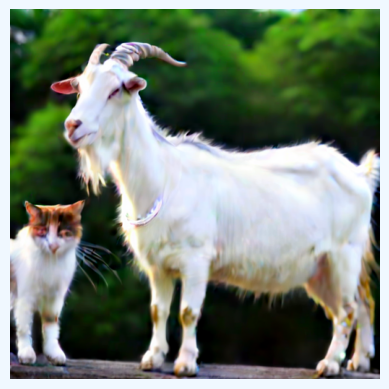

In [77]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import torchvision.transforms.functional as F

grid = make_grid(
    decoded_images[-1, 0], padding=0, nrow=10
)
def tensor_to_image(tensor):
    return F.to_pil_image(tensor.clamp(0, 1))

img = tensor_to_image(grid)
plt.axis("off")
plt.imshow(img)
plt.show()

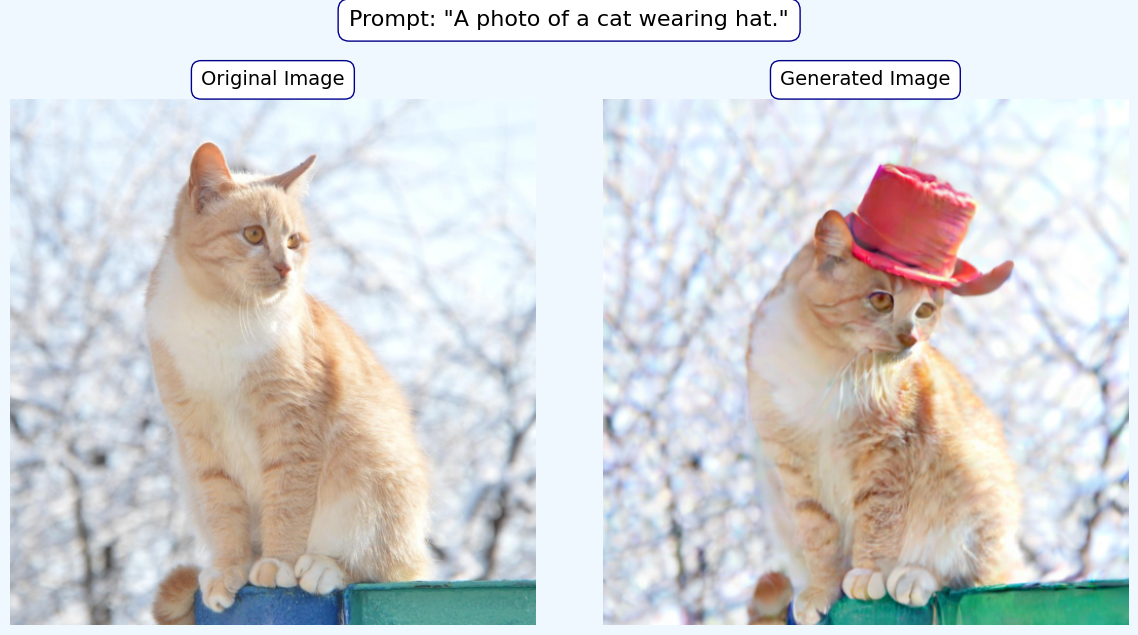

In [130]:
def display_before_after(original_image, generated_image, prompt, figsize=(12, 6)):
    """Display original and generated images side by side with decorative elements"""
    plt.figure(figsize=figsize)
    
    # Create a gradient background
    plt.rcParams['figure.facecolor'] = '#F0F8FF'
    
    # Plot original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.axis('off')
    plt.title('Original Image', fontsize=14, pad=10, 
              bbox=dict(facecolor='white', edgecolor='darkblue', boxstyle='round,pad=0.5'))
    
    # Add a decorative border
    plt.gca().spines['bottom'].set_color('darkblue')
    plt.gca().spines['top'].set_color('darkblue') 
    plt.gca().spines['right'].set_color('darkblue')
    plt.gca().spines['left'].set_color('darkblue')
    plt.gca().spines['bottom'].set_linewidth(2)
    plt.gca().spines['top'].set_linewidth(2)
    plt.gca().spines['right'].set_linewidth(2)
    plt.gca().spines['left'].set_linewidth(2)
    
    # Plot generated image
    plt.subplot(1, 2, 2)
    plt.imshow(generated_image)
    plt.axis('off')
    plt.title('Generated Image', fontsize=14, pad=10,
              bbox=dict(facecolor='white', edgecolor='darkblue', boxstyle='round,pad=0.5'))
    
    # Add a decorative border
    plt.gca().spines['bottom'].set_color('darkblue')
    plt.gca().spines['top'].set_color('darkblue')
    plt.gca().spines['right'].set_color('darkblue')
    plt.gca().spines['left'].set_color('darkblue')
    plt.gca().spines['bottom'].set_linewidth(2)
    plt.gca().spines['top'].set_linewidth(2)
    plt.gca().spines['right'].set_linewidth(2)
    plt.gca().spines['left'].set_linewidth(2)
    
    # Add prompt as a subtitle
    plt.suptitle(f'Prompt: "{prompt}"', fontsize=16, y=1.05,
                 bbox=dict(facecolor='white', edgecolor='darkblue', 
                          boxstyle='round,pad=0.5'))
    
    plt.tight_layout()
    plt.show()

# Generate the image
input_prompt = "A photo of a cat wearing hat."
text_embedding = train_ds.get_embed(input_prompt).unsqueeze(0)
cond_image = ds["original_image"][76].convert("RGB")
transformed_image = tensor_to_image(transform(cond_image))
cond_image = transform(cond_image).unsqueeze(0).to(device)
cond_image = vae.encode(cond_image).latent_dist.sample()
noise = torch.randn_like(cond_image, device=device)
null_text = model.null_condition_vector.expand(noise.size(0), -1).to(device)  # Use the null condition vector
null_image = model.null_image_vector.expand(noise.size(0), -1, -1, -1).to(device)
# Convert results to image

results = euler_method_with_dual_cfg(
    model,
    text_embedding,
    t_steps,
    dt,
    noise,
    cond_image,
    gamma_text=7.0,
    gamma_img=5.0,
    null_text=null_text,
    null_image=null_image,
)

decoded_images = latent_to_image(
    results, num_sample_from_batch=1, timesteps_to_sample=10
)

generated_img = tensor_to_image(decoded_images[-1, 0])

# Display the before/after comparison
display_before_after(transformed_image, generated_img, input_prompt)

In [131]:
decoded_images.shape

torch.Size([10, 1, 3, 512, 512])

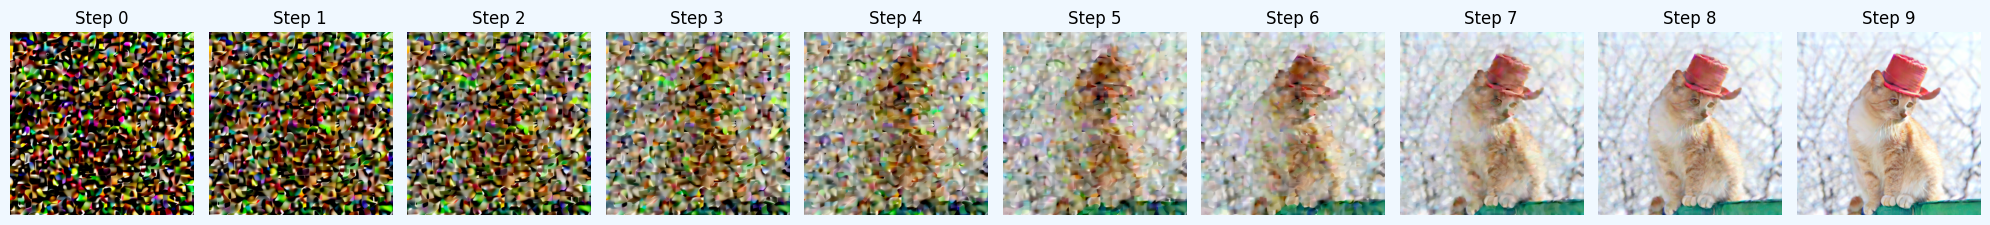

✅ Saved GIF to 'sample_11.gif'


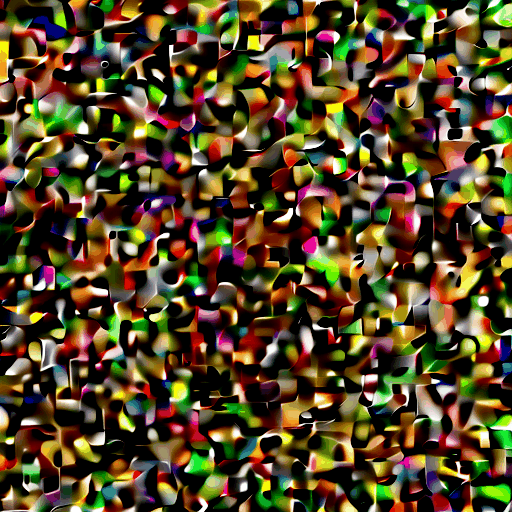

In [133]:
from IPython.display import display, Image as IPyImage

def show_and_save_sampling_progress(results, sample_idx=0, num_steps=9, save_path="sampling.gif", duration=300):
    """
    Hiển thị quá trình sampling (dạng ảnh) và đồng thời lưu thành file GIF.

    Args:
        traj (Tensor): Tensor 5D (T, B, C, H, W)
        sample_idx (int): Index của sample trong batch
        num_steps (int): Số bước sampling để hiển thị và lưu gif
        save_path (str): Đường dẫn file gif muốn lưu
        duration (int): Thời gian mỗi frame (milliseconds)
    """
    T = results.shape[0]
    assert num_steps <= T, "Số bước cần hiển thị phải nhỏ hơn hoặc bằng tổng số bước."

    # Lấy các bước cách đều từ 0 đến T-1
    indices = torch.linspace(0, T - 1, num_steps).long()

    fig, axes = plt.subplots(1, num_steps, figsize=(num_steps * 2, 6))
    frames = []

    for i, idx in enumerate(indices):
        if results.shape[1] == 1:
            # Nếu batch size là 1, chỉ cần lấy ảnh đầu tiên
            sample_idx = 0
        img_tensor = results[idx, sample_idx]  # (C, H, W)
        pil_img = tensor_to_image(img_tensor.cpu())
        frames.append(pil_img)

        # Hiển thị bằng matplotlib
        axes[i].imshow(pil_img)
        axes[i].axis("off")
        axes[i].set_title(f"Step {idx.item()}")

    plt.tight_layout()
    plt.show()

    # Save GIF
    frames[0].save(
        save_path,
        save_all=True,
        append_images=frames[1:],
        duration=duration,
        loop=0
    )
    print(f"✅ Saved GIF to '{save_path}'")

    display(IPyImage(filename=save_path))

sample_idx = 11
show_and_save_sampling_progress(decoded_images, sample_idx=sample_idx, num_steps=10, save_path=f"sample_{sample_idx}.gif")

In [134]:
torch.save(
    model.state_dict(),
    "./model/text_guided_image_generation_vae.pth"
)